In [1]:
% matplotlib inline

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Parameters
nruns = 12
ndiscard = 500 # discard the first this many frames
nbins = 100
frame_interval = 0.5 # nanoseconds

In [4]:
run_index = {
    0: '1OL5-notpx2-nophos',
    1: '1OL5-notpx2-phos',
    2: '1OL5-tpx2-nophos',
    3: '1OL5-tpx2-phos',
    4: '1OL7-notpx2-nophos',
    5: '1OL7-notpx2-phos',
    6: '1OL7-tpx2-nophos',
    7: '1OL7-tpx2-phos',
    8: '5L8K-notpx2-nophos',
    9: '5L8K-notpx2-phos',
    10: '5L8K-tpx2-nophos',
    11: '5L8K-tpx2-phos',
}

In [5]:
# Load in all data and report total amount of data
# convert to Angstroms and discard initial equilibration
runs = list()
for run in range(nruns):
    clones = np.load('data/run%d.npy' % run)
    nclones = len(clones)
    runs.append(clones)
    
for run in range(nruns):
    clones = runs[run]    
    nframes = sum([clone.shape[0] for clone in clones])
    aggregate_time = frame_interval * nframes
    print('%64s : %8.3f ns aggregate' % (run_index[run], aggregate_time))

                                              1OL5-notpx2-nophos : 95099.500 ns aggregate
                                                1OL5-notpx2-phos : 92019.500 ns aggregate
                                                1OL5-tpx2-nophos : 80160.000 ns aggregate
                                                  1OL5-tpx2-phos : 78409.500 ns aggregate
                                              1OL7-notpx2-nophos : 101600.000 ns aggregate
                                                1OL7-notpx2-phos : 103190.000 ns aggregate
                                                1OL7-tpx2-nophos : 101259.500 ns aggregate
                                                  1OL7-tpx2-phos : 103220.000 ns aggregate
                                              5L8K-notpx2-nophos : 82480.000 ns aggregate
                                                5L8K-notpx2-phos : 78750.000 ns aggregate
                                                5L8K-tpx2-nophos : 77570.000 ns aggregate
      

In [6]:
# Load trajectories
# convert to Angstroms and discard initial equilibration
runs = list()
for run in range(nruns):
    clones = np.load('data/run%d.npy' % run)
    nclones = len(clones)
    for clone_index in range(nclones):
            clones[clone_index] = clones[clone_index][ndiscard:,:] * 10 
    runs.append(clones)

In [7]:
for run in range(nruns):
    clones = runs[run]    
    nframes = sum([clone.shape[0] for clone in clones])
    aggregate_time = frame_interval * nframes
    print('%64s : %8.3f ns aggregate' % (run_index[run], aggregate_time))

                                              1OL5-notpx2-nophos : 70099.500 ns aggregate
                                                1OL5-notpx2-phos : 67019.500 ns aggregate
                                                1OL5-tpx2-nophos : 55160.000 ns aggregate
                                                  1OL5-tpx2-phos : 53409.500 ns aggregate
                                              1OL7-notpx2-nophos : 76600.000 ns aggregate
                                                1OL7-notpx2-phos : 78190.000 ns aggregate
                                                1OL7-tpx2-nophos : 76259.500 ns aggregate
                                                  1OL7-tpx2-phos : 78220.000 ns aggregate
                                              5L8K-notpx2-nophos : 57480.000 ns aggregate
                                                5L8K-notpx2-phos : 53810.000 ns aggregate
                                                5L8K-tpx2-nophos : 52570.000 ns aggregate
          

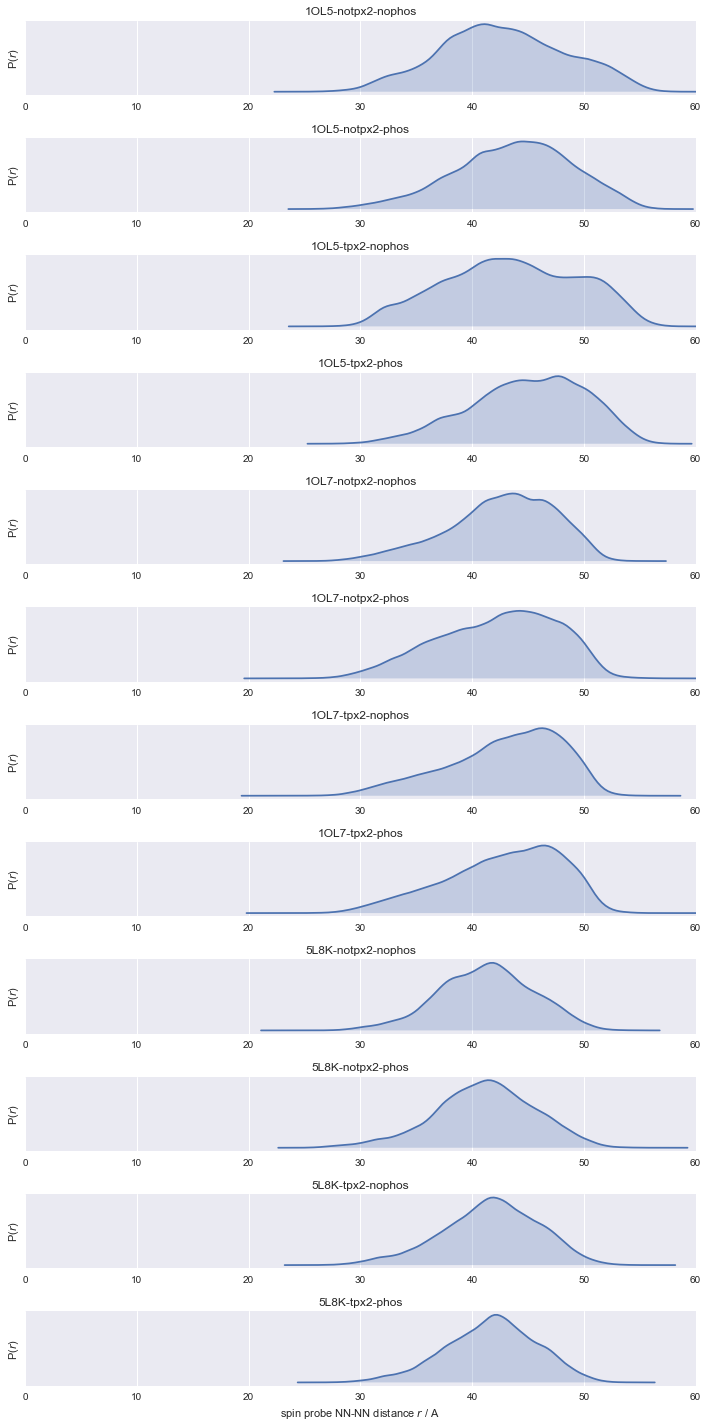

In [8]:
figure = plt.figure(figsize=[10,20])
maxdist = 60 # angstroms
bins = np.linspace(0, maxdist, nbins)
for run in range(nruns):    
    plt.subplot(nruns,1,run+1)
    clones = runs[run]    
    sns.kdeplot(np.concatenate([clone[:,0] for clone in clones]), shade=True).set(xlim=(0, maxdist))
    plt.yticks([])
    if run != (nruns-1):
        #plt.xticks([])
        pass
    else:
        plt.xlabel('spin probe NN-NN distance $r$ / A')
    plt.ylabel('P($r$)');
    plt.title(run_index[run])

figure.tight_layout()
figure.savefig('aurora-spin-probe-NN-NN-distances.pdf')

### Generate a kernel density estimate smoothed P(r) for Andrew Thompson to use to model DEER G(t) 

(resolution of 0.0166 nm from 1.5-10.0 nm)

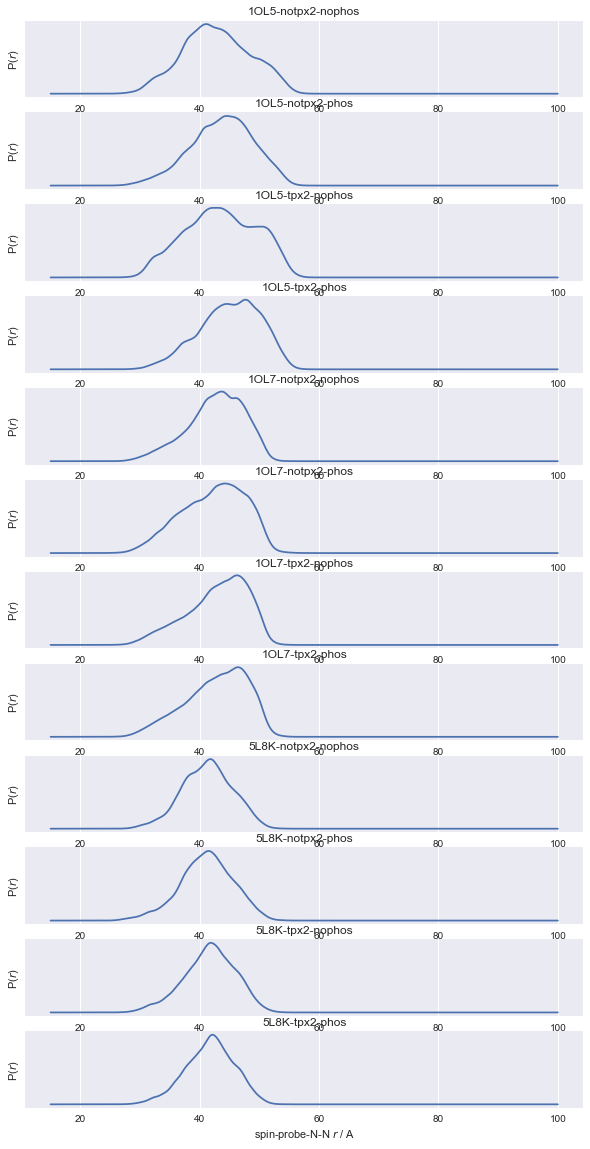

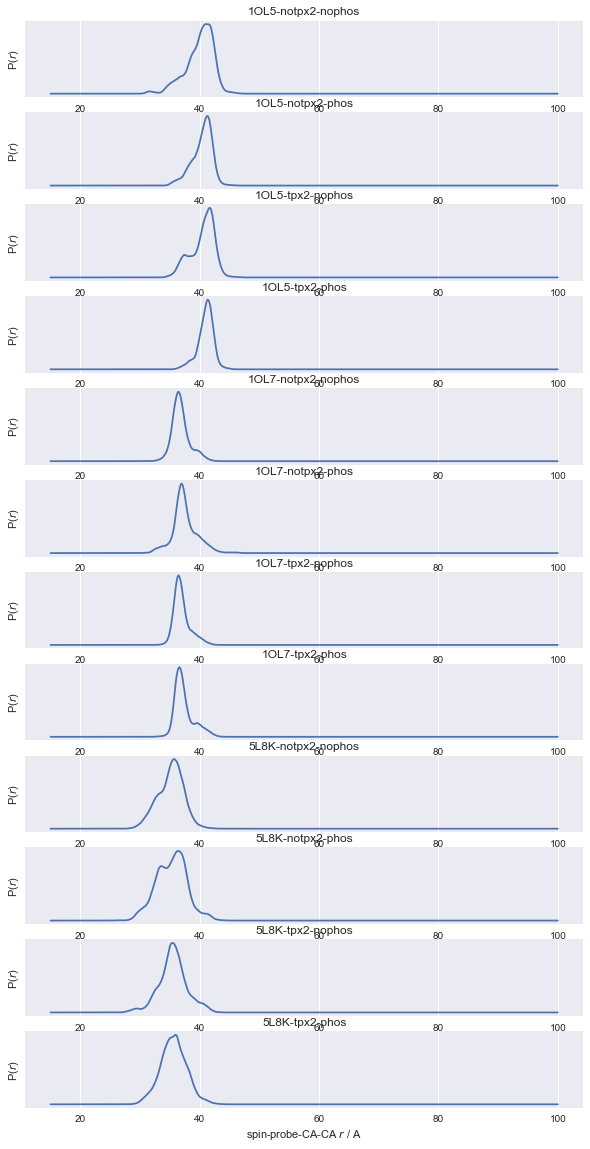

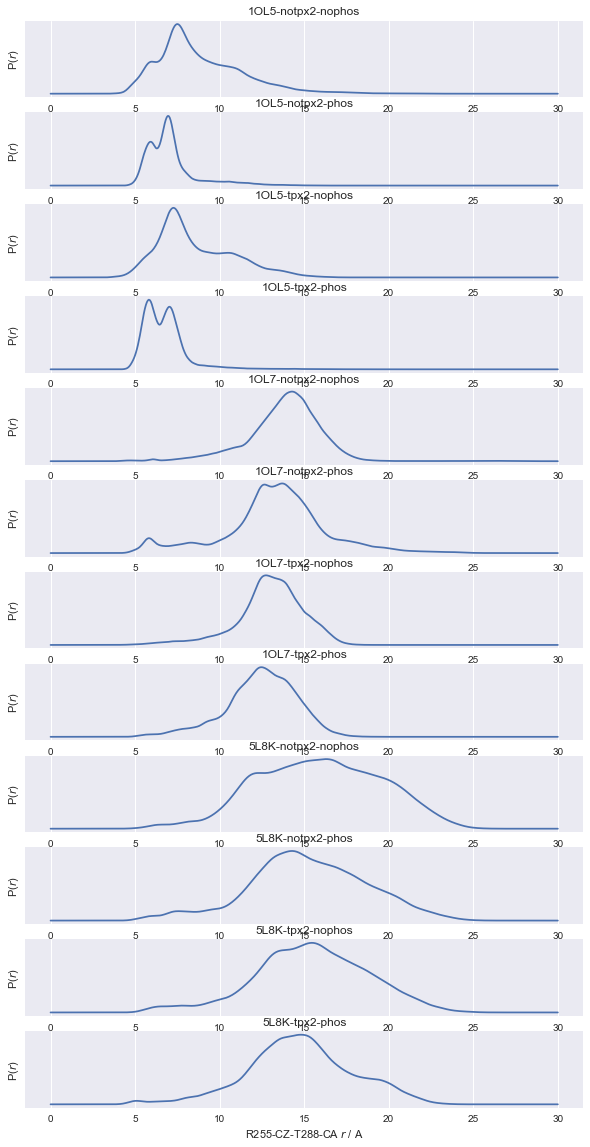

In [9]:
def write_kde_distance_distribution(distance_index, prefix, mindist=15, maxdist=100, nbins=512):
    """
    Write KDE-smoothed probability density p(r) to files.
    
    Parameters
    ----------
    distance_index : int
        The index of the distance to plot
    prefix : str
        Filename prefix
    mindist : float, optional, default=15
        Minimum distance in nm
    maxdist : float, optional, default=100
        Maximum distance in nm
    nbins : int, optional, default=512
        Number of bins
        
    """
    import statsmodels.nonparametric.kde as smnp
    figure = plt.figure(figsize=[10,20])
    for run in range(nruns):    
        plt.subplot(nruns,1,run+1)
        clones = runs[run]    
        fft = True
        kernel = "gau"
        data = np.concatenate([clone[:,distance_index] for clone in clones])
        kde = smnp.KDEUnivariate(data.astype(np.float))
        bw = 'scott'
        kde.fit(kernel, bw, fft)

        rvals = np.linspace(mindist, maxdist, nbins)
        Pvals = kde.evaluate(rvals)
        outfile = open('%s-%s.txt' % (prefix, run_index[run]),'w')
        for (r, P) in zip(rvals, Pvals):
            outfile.write('%f\t%f\n' % (r,P))
        outfile.close()

        plt.plot(rvals, Pvals, '-')
        plt.yticks([])
        if run != (nruns-1):
            #plt.xticks([])
            pass
        else:
            plt.xlabel('%s $r$ / A' % prefix)
        plt.ylabel('P($r$)');
        plt.title(run_index[run])

write_kde_distance_distribution(0, 'spin-probe-N-N')
write_kde_distance_distribution(1, 'spin-probe-CA-CA')
write_kde_distance_distribution(2, 'R255-CZ-T288-CA', mindist=0, maxdist=30)

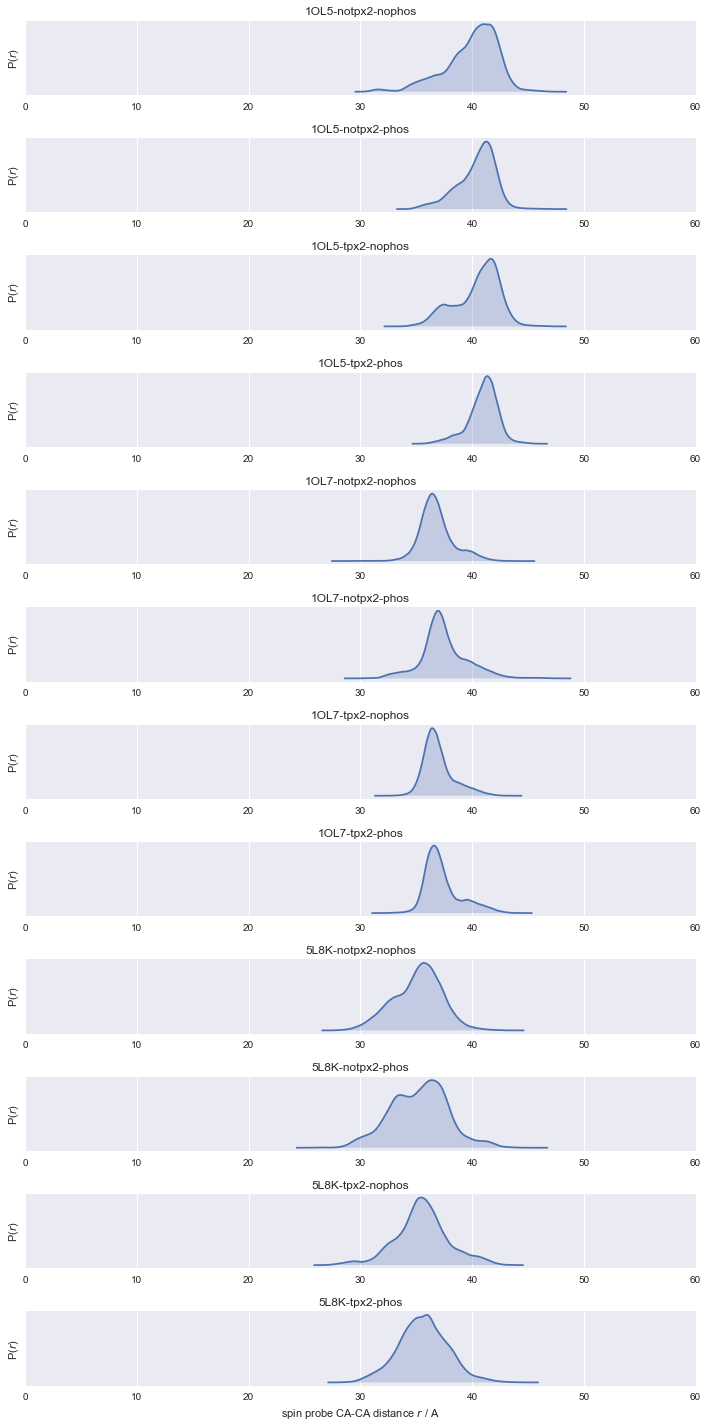

In [10]:
figure = plt.figure(figsize=[10,20])
maxdist = 60 # angstroms
bins = np.linspace(0, maxdist, nbins)
for run in range(nruns):    
    plt.subplot(nruns,1,run+1)
    clones = runs[run]    
    sns.kdeplot(np.concatenate([clone[:,1] for clone in clones]), shade=True).set(xlim=(0, maxdist))
    plt.yticks([])
    if run != (nruns-1):
        #plt.xticks([])
        pass
    else:
        plt.xlabel('spin probe CA-CA distance $r$ / A')
    plt.ylabel('P($r$)');
    plt.title(run_index[run])

figure.tight_layout()
figure.savefig('aurora-spin-probe-CA-CA-distances.pdf')

## How much data do we have?

In [11]:
for run in range(nruns):
    clones = runs[run]    
    nframes = sum([clone.shape[0] for clone in clones])
    aggregate_time = frame_interval * nframes
    print('%64s : %8.3f ns aggregate' % (run_index[run], aggregate_time))

                                              1OL5-notpx2-nophos : 70099.500 ns aggregate
                                                1OL5-notpx2-phos : 67019.500 ns aggregate
                                                1OL5-tpx2-nophos : 55160.000 ns aggregate
                                                  1OL5-tpx2-phos : 53409.500 ns aggregate
                                              1OL7-notpx2-nophos : 76600.000 ns aggregate
                                                1OL7-notpx2-phos : 78190.000 ns aggregate
                                                1OL7-tpx2-nophos : 76259.500 ns aggregate
                                                  1OL7-tpx2-phos : 78220.000 ns aggregate
                                              5L8K-notpx2-nophos : 57480.000 ns aggregate
                                                5L8K-notpx2-phos : 53810.000 ns aggregate
                                                5L8K-tpx2-nophos : 52570.000 ns aggregate
          

## Plot only +TPX2 +phos

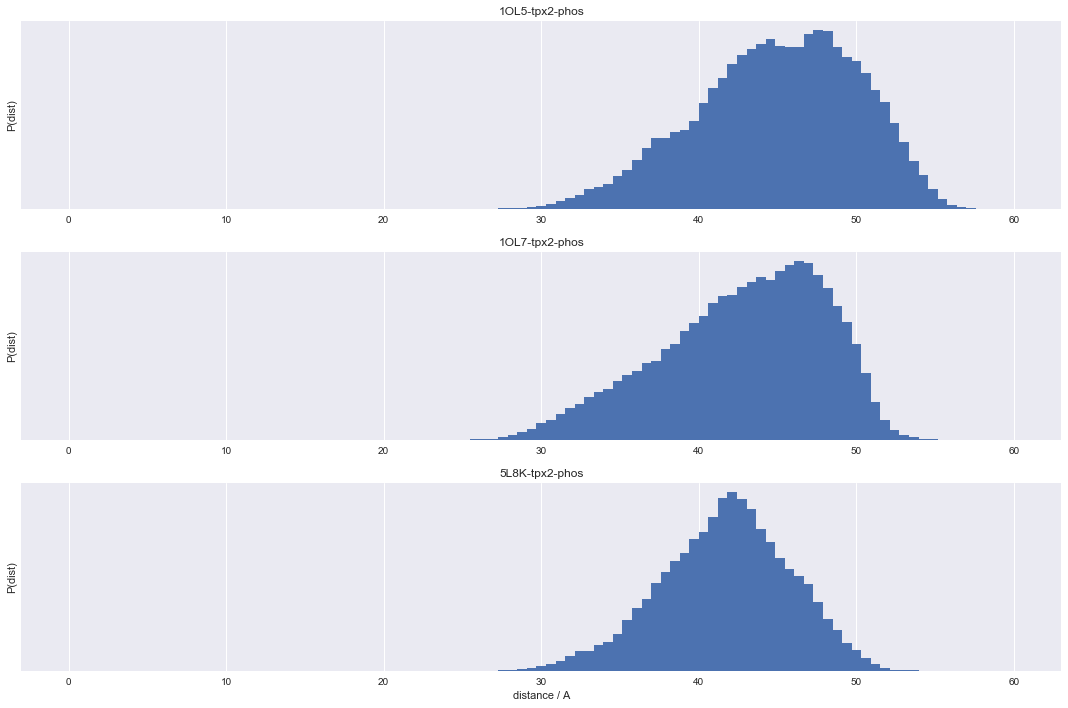

In [12]:
runs_to_plot = list()
for run in range(nruns):
    if '-tpx2-phos' in run_index[run]:
        runs_to_plot.append(run)
        
figure = plt.figure(figsize=[15,10])
maxdist = 60 # angstroms
bins = np.linspace(0, maxdist, nbins)
for (index, run) in enumerate(runs_to_plot):    
    plt.subplot(len(runs_to_plot),1,index+1)
    clones = runs[run]    
    plt.hist(np.concatenate([clone[:,0] for clone in clones]), bins)
    plt.yticks([])
    if run != (nruns-1):
        #plt.xticks([])
        pass
    else:
        plt.xlabel('distance / A')
    plt.ylabel('P(dist)');
    plt.title(run_index[run])

figure.tight_layout()

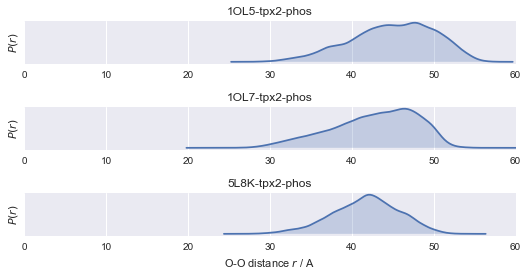

In [13]:
runs_to_plot = list()
for run in range(nruns):
    if '-tpx2-phos' in run_index[run]:
        runs_to_plot.append(run)
        
figure = plt.figure(figsize=[7.5,4])
maxdist = 60 # angstroms
bins = np.linspace(0, maxdist, nbins)
for (index, run) in enumerate(runs_to_plot):    
    plt.subplot(len(runs_to_plot),1,index+1)
    clones = runs[run]    
    sns.kdeplot(np.concatenate([clone[:,0] for clone in clones]), shade=True).set(xlim=(0, maxdist))
    plt.yticks([])
    if run != (nruns-1):
        #plt.xticks([])
        pass
    else:
        plt.xlabel('O-O distance $r$ / A')
    plt.ylabel('$P(r)$');
    plt.title(run_index[run])
    
figure.tight_layout()
figure.savefig('aurora-tpx2-phos-OO-distance.pdf')

## Plot spin probe NN-NN vs CA-CA

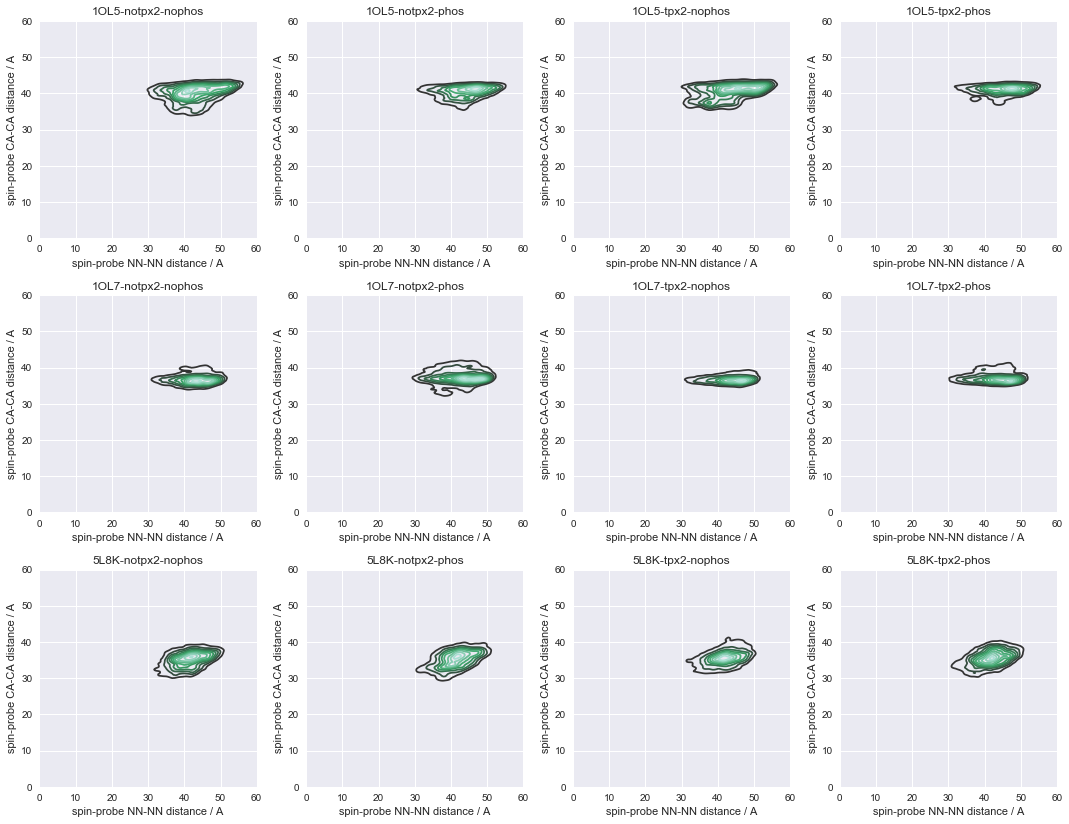

In [14]:
figure = plt.figure(figsize=[15,15])
maxdist = 60 # angstroms
thin = 5
for run in range(nruns):    
    plt.subplot(4,4,run+1)
    clones = runs[run]    
    OO_distance = np.concatenate([clone[::thin,0] for clone in clones])
    CA_distance = np.concatenate([clone[::thin,1] for clone in clones])
    sns.kdeplot(OO_distance, data2=CA_distance)
    plt.xlabel('spin-probe NN-NN distance / A')
    plt.ylabel('spin-probe CA-CA distance / A')
    plt.axis('square')
    plt.title(run_index[run])
    plt.xlim(0, maxdist)
    plt.ylim(0, maxdist)

figure.tight_layout()
figure.savefig('aurora-spin-probe-distance-comparison-contour.png', dpi=300)

## Plot spin probe NN-NN vs R255-T288 distance

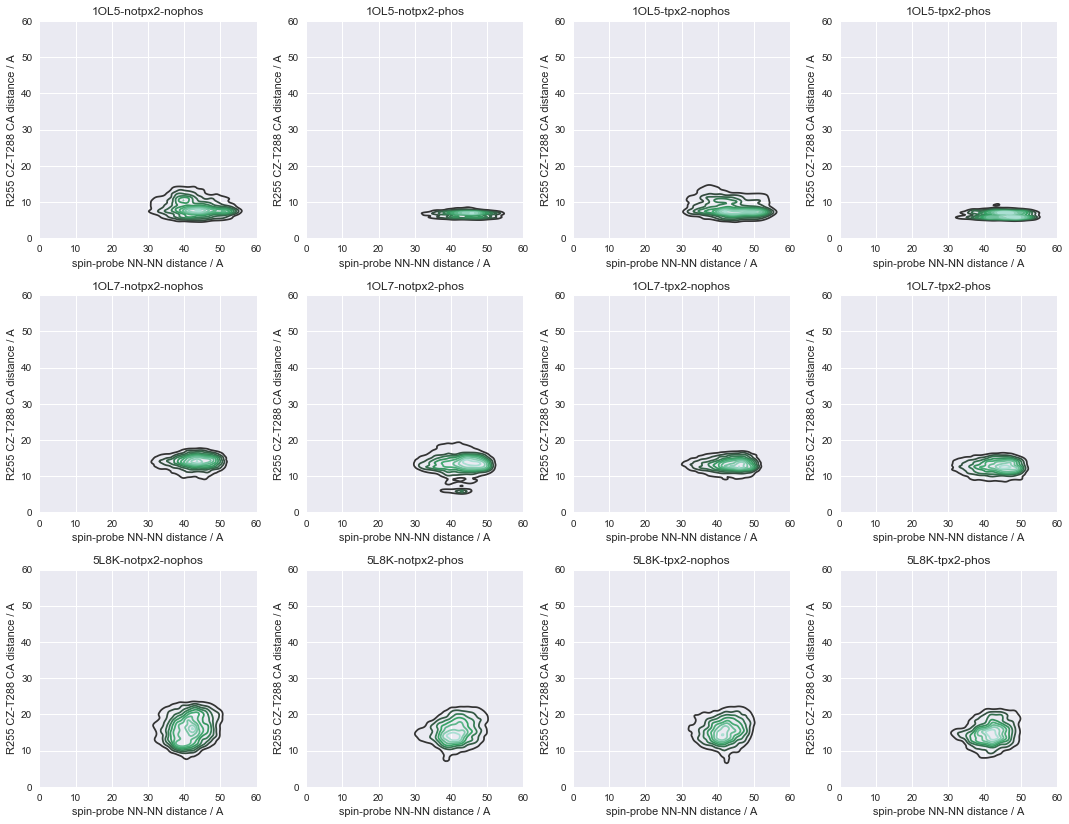

In [15]:
figure = plt.figure(figsize=[15,15])
maxdist = 60 # angstroms
thin = 10
for run in range(nruns):    
    plt.subplot(4,4,run+1)
    clones = runs[run]    
    OO_distance = np.concatenate([clone[::thin,0] for clone in clones])
    RT_distance = np.concatenate([clone[::thin,2] for clone in clones])
    sns.kdeplot(OO_distance, data2=RT_distance)
    plt.xlabel('spin-probe NN-NN distance / A')
    plt.ylabel('R255 CZ-T288 CA distance / A')
    plt.axis('square')
    plt.title(run_index[run])
    plt.xlim(0, maxdist)
    plt.ylim(0, maxdist)

figure.tight_layout()
figure.savefig('aurora-distance-comparison-contour.png', dpi=300)

/Users/choderaj/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


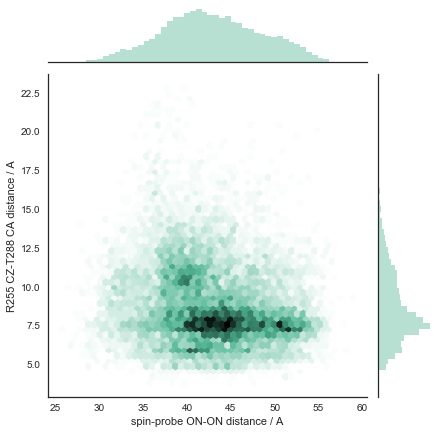

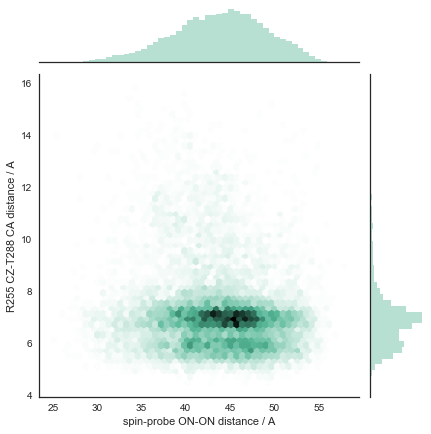

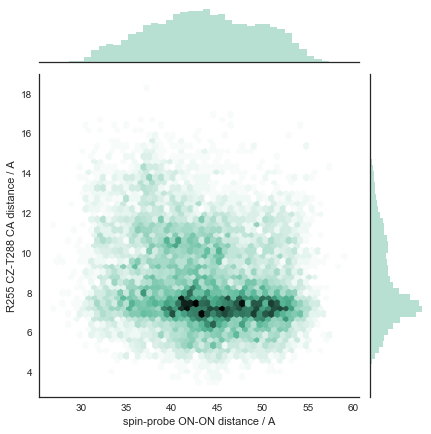

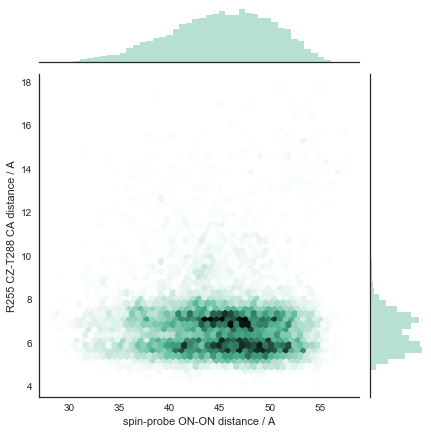

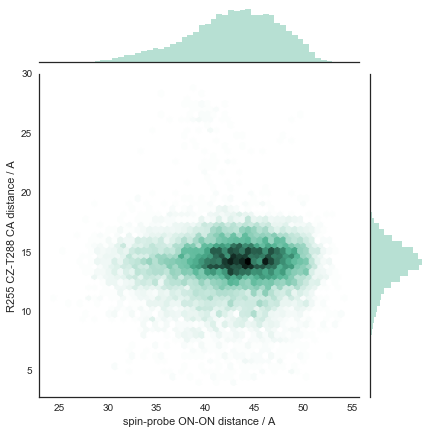

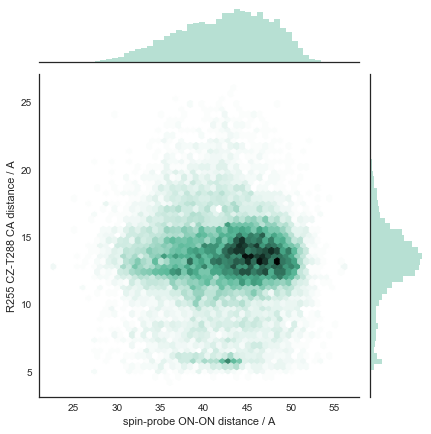

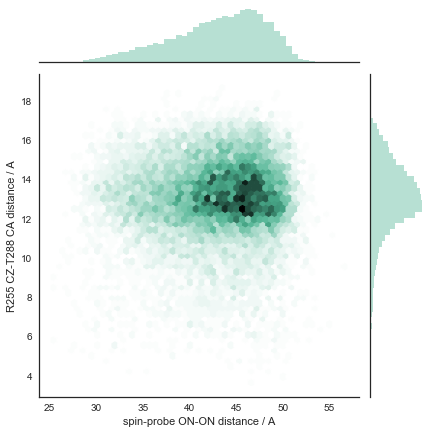

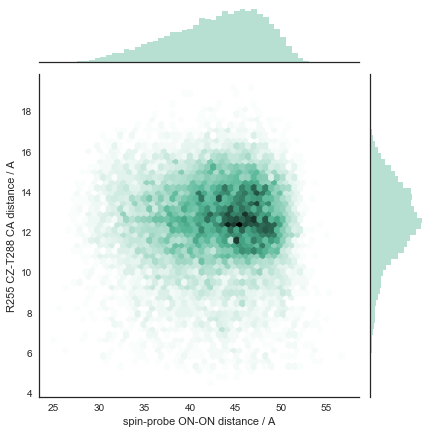

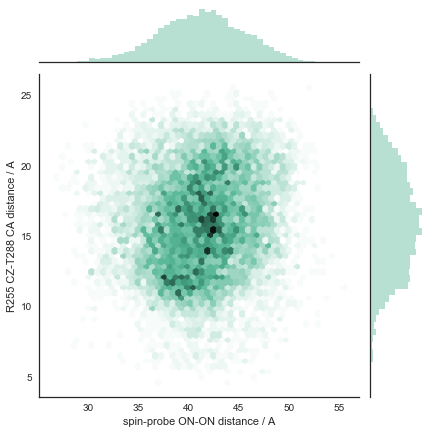

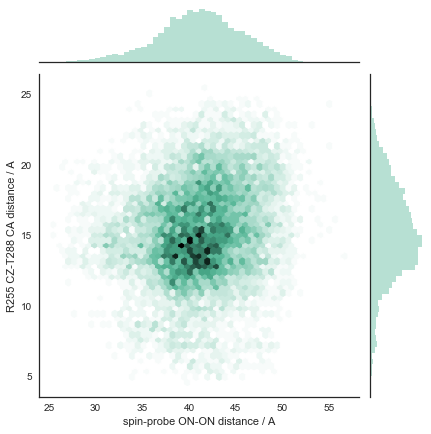

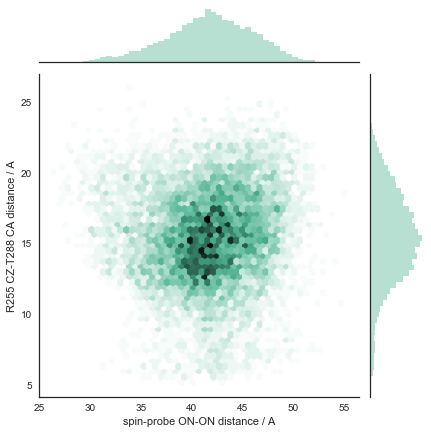

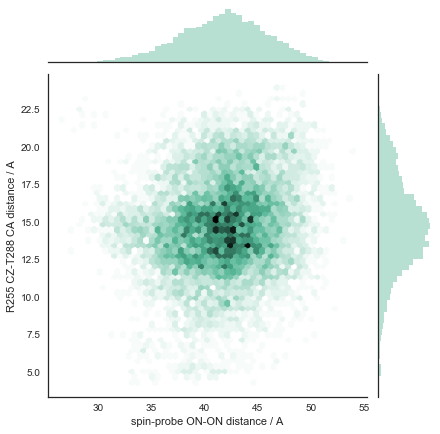

In [16]:
maxdist = 60 # angstroms
thin = 10
sns.set(style="white", color_codes=True);
for run in range(nruns):    
    figure = plt.figure(figsize=[5,5]);
    name = run_index[run]
    clones = runs[run]    
    OO_distance = np.concatenate([clone[::thin,0] for clone in clones])
    RT_distance = np.concatenate([clone[::thin,2] for clone in clones])
    #sns.jointplot(OO_distance, RT_distance, kind="hex", color="#4CB391", stat_func=None, xlim=(0,maxdist), ylim=(0,maxdist))
    sns.jointplot(OO_distance, RT_distance, kind="hex", color="#4CB391", stat_func=None, gridsize=50).set_axis_labels("spin-probe ON-ON distance / A", "R255 CZ-T288 CA distance / A");
    #plt.xlabel('spin-probe ON-ON distance / A')
    #plt.ylabel('R255 CZ-T288 CA distance / A')
    #plt.axis('square')
    #plt.title(name)
    #plt.xlim(0, maxdist)
    #plt.ylim(0, maxdist)

    #figure.tight_layout()
    plt.gcf().savefig('aurora-distance-comparison-hexbin-%s.png' % name, dpi=300);

## Compute DFG loop distances

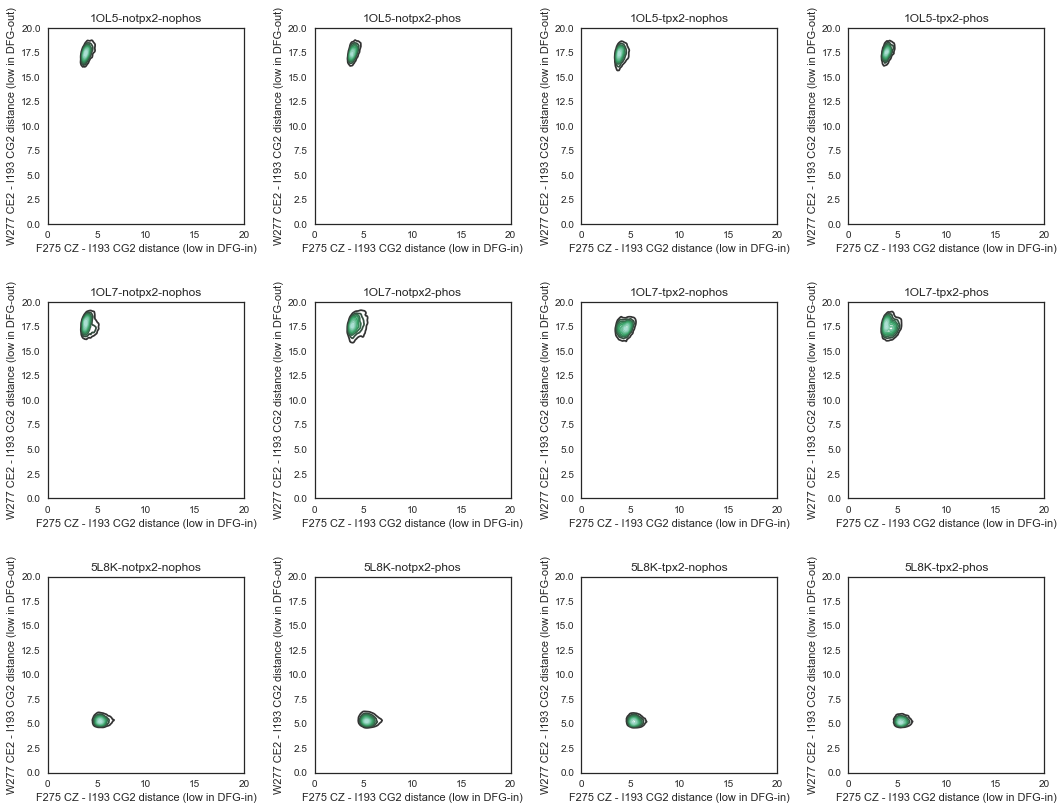

In [17]:
figure = plt.figure(figsize=[15,15])
xmax = 20 # angstroms
ymax = 20
thin = 10

xlabel = 'F275 CZ - I193 CG2 distance (low in DFG-in)'
ylabel = 'W277 CE2 - I193 CG2 distance (low in DFG-out)'
  
for run in range(nruns):    
    plt.subplot(4,4,run+1)
    clones = runs[run]    
    OO_distance = np.concatenate([clone[::thin,3] for clone in clones])
    RT_distance = np.concatenate([clone[::thin,4] for clone in clones])
    sns.kdeplot(OO_distance, data2=RT_distance)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('square')
    plt.title(run_index[run])
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

figure.tight_layout()
figure.savefig('aurora-DFG-contour.png', dpi=300)

/Users/choderaj/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


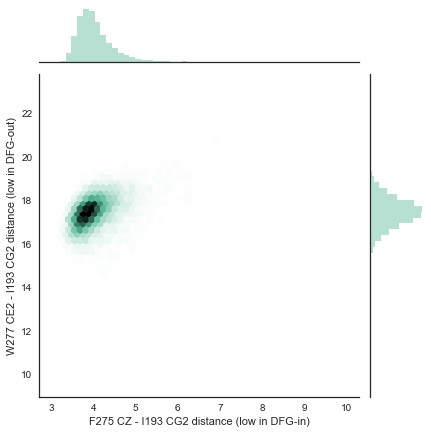

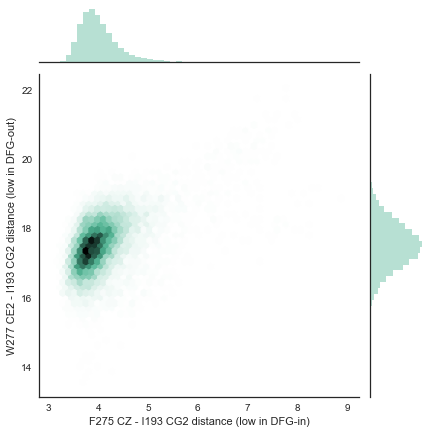

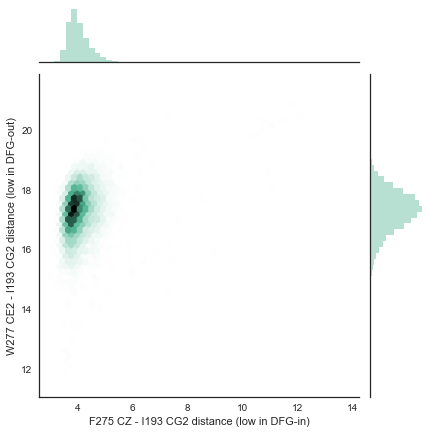

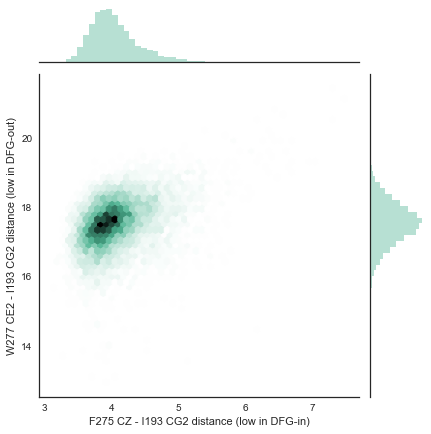

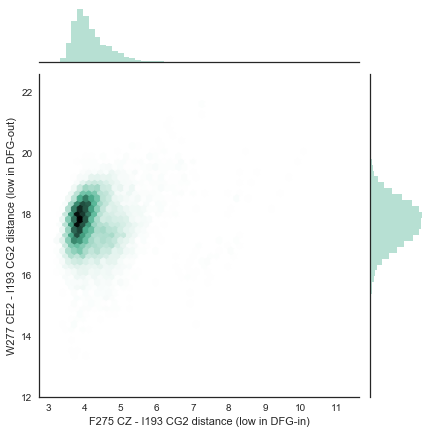

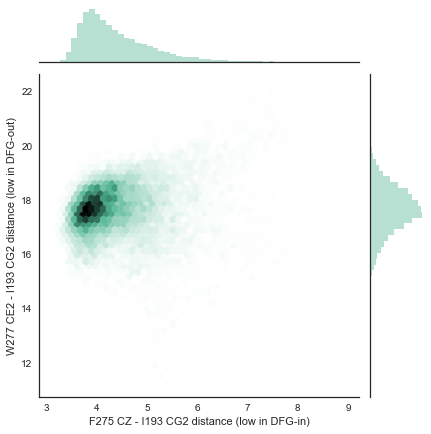

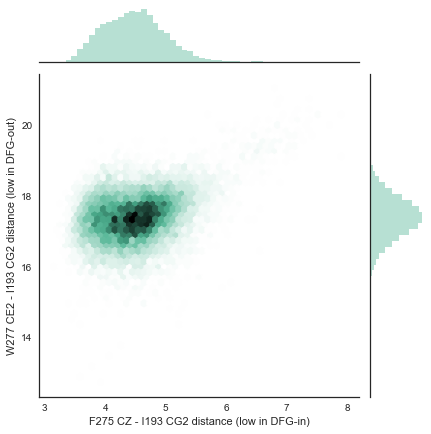

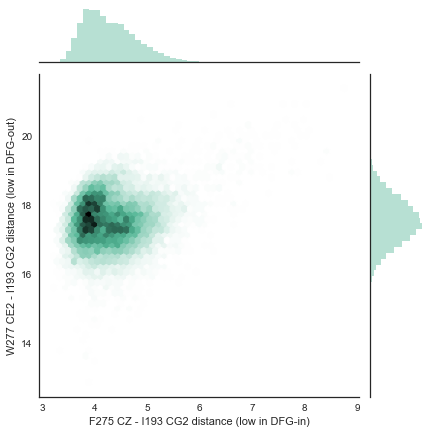

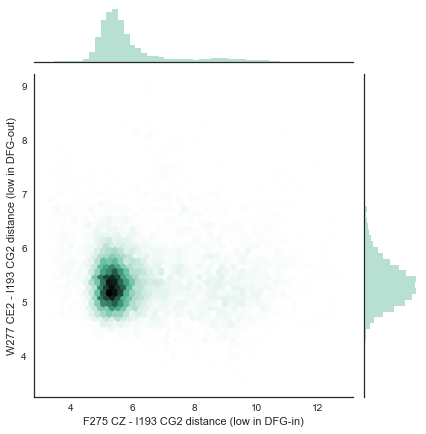

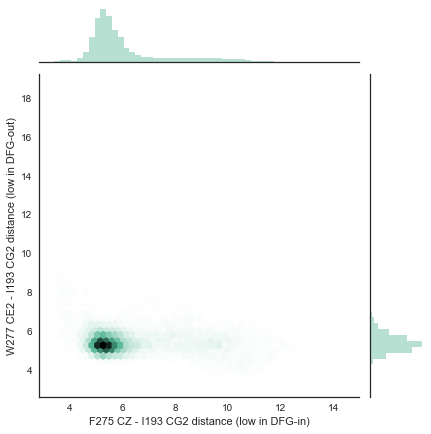

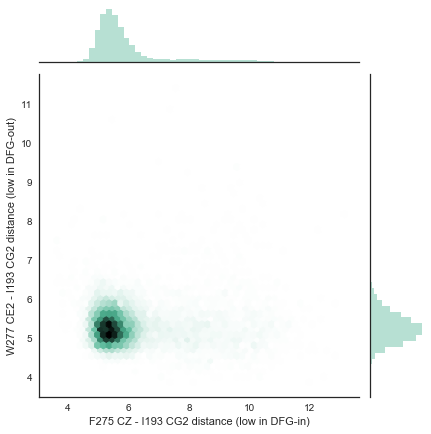

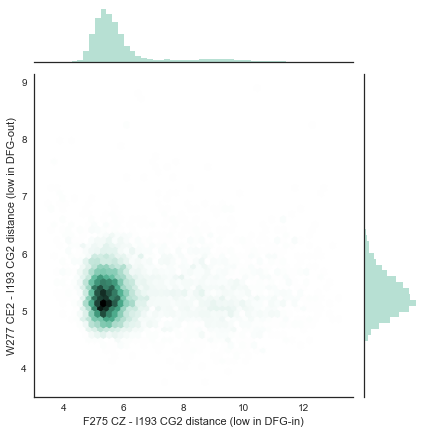

In [18]:
maxdist = 60 # angstroms
thin = 10

xlabel = 'F275 CZ - I193 CG2 distance (low in DFG-in)'
ylabel = 'W277 CE2 - I193 CG2 distance (low in DFG-out)'
        
sns.set(style="white", color_codes=True);
for run in range(nruns):    
    figure = plt.figure(figsize=[5,5]);
    name = run_index[run]
    clones = runs[run]    
    OO_distance = np.concatenate([clone[::thin,3] for clone in clones])
    RT_distance = np.concatenate([clone[::thin,4] for clone in clones])
    sns.jointplot(OO_distance, RT_distance, kind="hex", color="#4CB391", stat_func=None, gridsize=50).set_axis_labels(xlabel, ylabel);
    #plt.xlabel('spin-probe ON-ON distance / A')
    #plt.ylabel('R255 CZ-T288 CA distance / A')
    #plt.axis('square')
    #plt.title(name)
    #plt.xlim(0, maxdist)
    #plt.ylim(0, maxdist)

    #figure.tight_layout()
    plt.gcf().savefig('aurora-DFG-hexbin-%s.png' % name, dpi=300);